## Processing of imaging data using max-projection (i.e. data compressed to 3D)

This preprocessing pipeline can be used to process  single-plane imaging data (3D) or volume imaging data (4D). In the latter case, the volume is collapsed through a max projection.

In [27]:
from ScanImageTiffReader import ScanImageTiffReader
import json
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import numpy as np
import matplotlib.patches as ppatch

from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

import napari #python -m pip install "napari[all]"
import xarray as xr
import pandas as pd

%gui qt5
%config Completer.use_jedi = False  #magic to fix autocomplete issue

In [2]:
#import shapely
from shapely.geometry.polygon import LinearRing, Polygon, LineString
from shapely.geometry.point import Point
#import matplotlib.affinity
import shapely.affinity

In [3]:
import sys
sys.executable

'c:\\Users\\FANG\\anaconda3\\envs\\fly2p\\python.exe'

In [4]:
from fly2p.viz.viz import myAxisTheme, plotDFFheatmap
import fly2p.preproc.imgPreproc as imp
from fly2p.preproc.scanImageUtils import getSIbasicMetadata, getSIMetadict, loadvolume

In [5]:
from fly2p.viz.viz import generateEBellipse, constructEBROIs, plotEBshapelyROIs, getDFFfromEllipseROI

#### Set paths to data files and plot directory

In [36]:
# dataDir = '../sample/'
dataDir = 'Y:\\Abby\\Data\\Fly2PImaging\\SS96_x_sCaMP72E5\\f02'
rawTiff = 'SS96_x_sCaMP72E5_f02_4to6_EB_whiteBar20_dark_00001.tif'
genotype = 'SS96_x_sCaMP72E5'
flyID = 'f02'
trial = 't01'
region = 'ellipsoid body'
        
saveDir = dataDir
preprocDir = dataDir
# Generate directory where to save plots
if not exists(saveDir): makedirs(saveDir)
if not exists(preprocDir): makedirs(preprocDir)

#### Load data and perform motion correction

In [46]:
mytiffreader = ScanImageTiffReader(sep.join([dataDir, rawTiff]))
basicMetadat = getSIbasicMetadata(mytiffreader.metadata())
basicMetadat["CaCh"] = 1 # give channel identity
SImetadict = getSIMetadict(mytiffreader.metadata())

SI.VERSION_COMMIT = '5066720ab90fa5f9bfc89c972f39266d0afd7c49'
SI.VERSION_MAJOR = 2022
SI.VERSION_MINOR = 1
SI.VERSION_UPDATE = 0


In [47]:
basicMetadat

{'nCh': 2,
 'fpsscan': 80.8956,
 'discardFBFrames': 'true',
 'nDiscardFBFrames': 2,
 'fpv': 13,
 'nVols': 3029,
 'stackZStepSize': 3.0,
 'scanVolumeRate': 6.22274,
 'fovCoords': {'p00': [-20.25, -20.25],
  'p10': [20.25, 20.25],
  'p01': [20.25, -20.25],
  'p11': [-20.25, 20.25]},
 'xrange_um': 40.5,
 'yrange_um': 40.5,
 'CaCh': 1}

In [48]:
# Load data: With larger file sizes, the scanimage loader fails (idk why)
stack = loadvolume(sep.join([dataDir, rawTiff]), basicMetadat, selectCaChan=True)
imgStack = imp.stack2xarray(stack, basicMetadat)

(3029, 180, 180)

Check if reference image is good: It should not be to biased by transient activity peaks.

C:\Users\FANG\AppData\Local\Temp\ipykernel_2144\2492259011.py:11: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


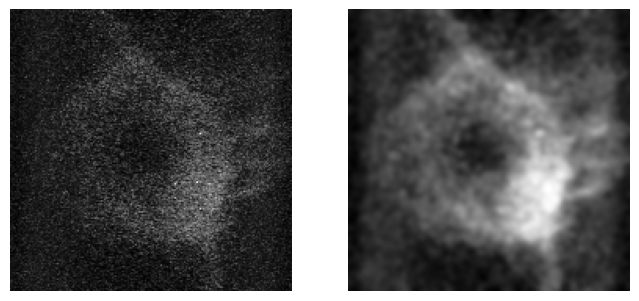

In [49]:
# Set reference image
stackMP = np.max(imgStack, axis=1) # max projection over volume

numRefImg = 20
refstart = 100
locRefImg = round(stackMP['volumes [s]'].size/2)

# Generate reference image
refImg = np.mean(stackMP[locRefImg:locRefImg+numRefImg,:,:],axis=0) + np.mean(stackMP[refstart:refstart+numRefImg,:,:],axis=0)

from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='Greys_r', origin='lower'); axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='Greys_r', origin='lower'); axs[1].axis('off');

perform motion correction on a single plane/max projection
. . . . . . . . . . . . . . . . . . . . 

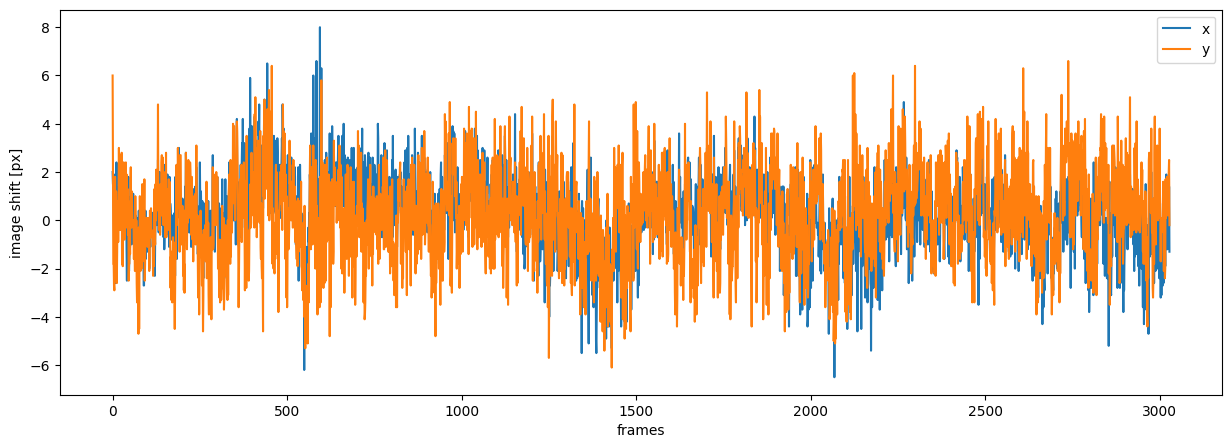

In [50]:
# If there are unreasonable shifts select "doFilter=True".

shift = imp.computeMotionShift(stackMP, refImg, 10, 2, doFilter=False, stdFactor=4, showShiftFig=True)

# stack max projection (MP) motion correction (MC)
stackMPMC = imp.motionCorrection(stackMP, shift)


#shift = imp.computeMotionShift(stackMP, refImg, 10, 2, doFilter=True, stdFactor=4, showShiftFig=True)
#stackMPMC = imp.motionCorrection(stackMP, shift)

#### Compute DFF

In [51]:
## Settings
# settings for Savitzky-Golay filter (default: 3rd order, 7 frames)
order = 3
window = 7

# Currently F_0 is estimated for each pixel on the whole time series (ok, if time series is short)
baseLinePercent = 10
offset = 0.0001

***Specify region for background subtraction***
* Paint a small region named "background" using a brush in the Labels menu in the napari gui. This region should not overlap with the intended signal roi.
* If there is an existing mask placed in the preprocessing folder of the fly and/or tiral, it will be loaded automatically
* If subtracting using rolling ball, skip the next 2 cells

In [52]:
# you can draw a mask on the foreground
viewer = napari.view_image(stackMPMC.mean(axis=0), contrast_limits=[stackMPMC.data.mean(axis=0).min(),np.percentile(stackMPMC.mean(axis=0), 99.9)])

if exists(sep.join([preprocDir,'background_3d.npy'])):
    background = np.load(sep.join([preprocDir,'background_3d.npy'])) 
    viewer.add_labels(background, name='background')

c:\Users\FANG\anaconda3\envs\fly2p\lib\site-packages\numpy\core\numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
c:\Users\FANG\anaconda3\envs\fly2p\lib\site-packages\napari\layers\shapes\shapes.py:2545: RuntimeWarning: invalid value encountered in cast
  shape = np.ceil(
c:\Users\FANG\anaconda3\envs\fly2p\lib\site-packages\napari\layers\shapes\shapes.py:2545: RuntimeWarning: invalid value encountered in cast
  shape = np.ceil(
c:\Users\FANG\anaconda3\envs\fly2p\lib\site-packages\napari\layers\shapes\shapes.py:2545: RuntimeWarning: invalid value encountered in cast
  shape = np.ceil(
c:\Users\FANG\anaconda3\envs\fly2p\lib\site-packages\napari\layers\base\base.py:1583: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
c:\Users\FANG\anaconda3\envs\fly2p\lib\site-packages\napari\layers\shapes\shapes.py:2545: Ru

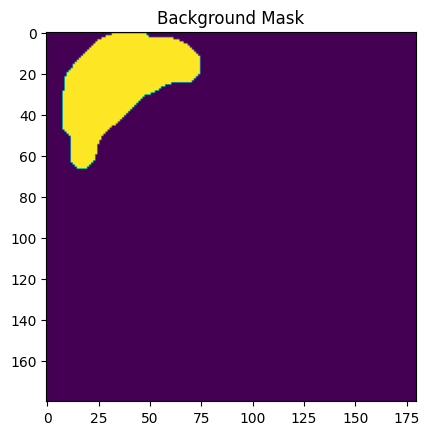

In [53]:
background = viewer.layers["background"].data

if not exists(preprocDir): makedirs(sep.join([preprocDir]))
np.save(sep.join([preprocDir,'background_3d']), background)
viewer.close()

plt.imshow(background);
plt.title("Background Mask");

(3029,)

In [54]:
dffStack, stackF0 = imp.computeDFF(stackMPMC, order, window, baseLinePercent, offset)
dffXarray = imp.stack2xarray(dffStack, basicMetadat, data4D = False)
F0Xarray = imp.refStack2xarray(stackF0, basicMetadat, data4D = False)

processing 3d stack


In [141]:
"""#find the average fluorescence per timestep
for k in range(dffXarray.shape[0]-1):
    meanDFF = np.nanmean(dffXarray[k,:,:])

meanDFF"""

()

In [151]:
meanDFF = np.nanmean(dffXarray, axis=1)
meanDFF2= np.nanmean(meanDFF, axis=1)

In [152]:
meanDFF2.shape

(3029,)

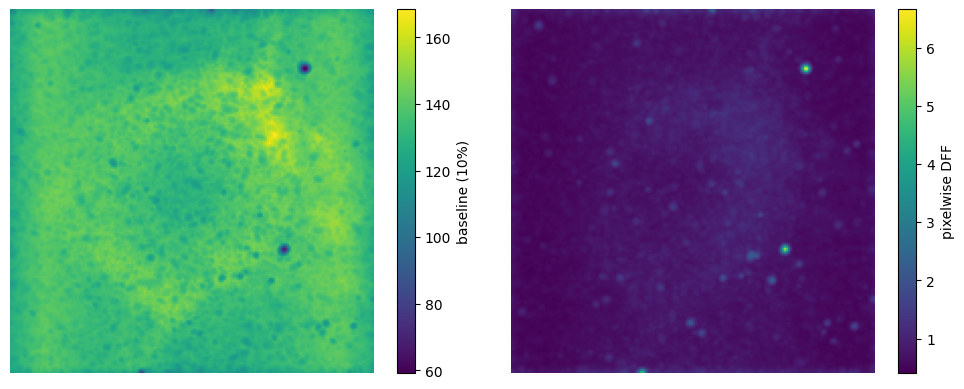

In [55]:
dffMP = np.max(dffStack,axis=0)
fig, ax = plt.subplots(1,2,figsize=(10,4))
cb = ax[0].imshow(stackF0,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[0], label='baseline ({}%)'.format(baseLinePercent))
ax[0].axis('off')
cb = ax[1].imshow(dffMP,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[1], label='pixelwise DFF')
ax[1].axis('off')
fig.tight_layout()
#viewerdff = napari.view_image(dffStackMC)
fig.savefig(saveDir+sep+'BaselineAndDFF_MIP_3d.pdf')

### Generate ROIs automatically
We will do this here only for pixels within a manually drawn mask, but it also works fine without a mask.

In [19]:
# you can draw a mask to constraint which pixels will be included in corrleation analysis
viewer = napari.view_image(refImgFilt)
if exists(sep.join([preprocDir,'mask_3d.npy'])):
    mask = np.load(sep.join([preprocDir,'mask_3d.npy'])) 
    viewer.add_labels(mask, opacity=0.2)



In [22]:
# add ellipse layer to napari
# user uses selection tool to adjust axes of ellipse
ellipse = np.array([[85,28],[28,85],[84,138],[141,83]])
shapes_layer = viewer.add_shapes(name='mask')
shapes_layer.add(
    ellipse,
    shape_type=['ellipse'],
    edge_width=1,
    face_color='#ffff7fff'
)
shapes_layer.opacity = 0.1

c:\Users\FANG\anaconda3\envs\fly2p\lib\site-packages\numpy\core\numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
c:\Users\FANG\anaconda3\envs\fly2p\lib\site-packages\napari\layers\shapes\shapes.py:2545: RuntimeWarning: invalid value encountered in cast
  shape = np.ceil(
c:\Users\FANG\anaconda3\envs\fly2p\lib\site-packages\napari\layers\shapes\shapes.py:2545: RuntimeWarning: invalid value encountered in cast
  shape = np.ceil(
c:\Users\FANG\anaconda3\envs\fly2p\lib\site-packages\napari\layers\shapes\shapes.py:2545: RuntimeWarning: invalid value encountered in cast
  shape = np.ceil(


In [40]:
# find major and minor axes from ellipse

# this gives the points on the corners of the box, not the shape
sq = np.array([viewer.layers['mask'].data])
sq.shape
sq = np.squeeze(sq)
sq
# calculate major and minor axes
# find center of ellipse
# formula for equi-arcs of ellipse

array([[ 86.0381909 ,   3.56499617],
       [ -1.38308629,  90.8468135 ],
       [ 75.52941138, 163.02886589],
       [162.78600833,  78.64489461]])

In [28]:
viewer.layers['mask'].data

[array([[ 85.99136266,   3.61110111],
        [ -7.15197464,  96.52654175],
        [ 69.9537834 , 168.51831979],
        [162.83283656,  78.59878967]])]

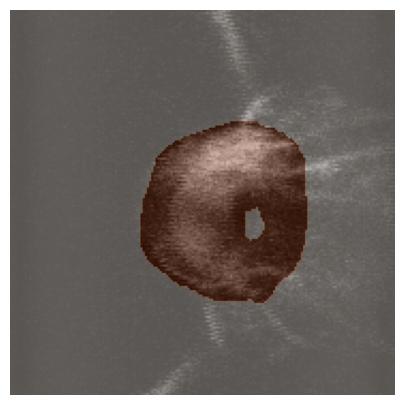

In [58]:
mask = viewer.layers["mask"]
viewer.close()
if not exists(sep.join([preprocDir,'mask_3d.npy'])):
    if not exists(sep.join([preprocDir])): makedirs(sep.join([preprocDir]))
    np.save(sep.join([preprocDir,'mask']), mask.data)
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(refImg,cmap='Greys_r',origin='upper')
ax.axis('off');
ax.imshow(mask.data, cmap='Oranges', alpha=0.35)
fig.savefig(saveDir+sep+'mask_3d.pdf')

In [59]:
from sklearn.cluster import KMeans
nclst = 10

toClust = dffStack[:,mask.data>0]
kmeans = KMeans(n_clusters=nclst)
kmeans.fit(toClust.T)

kmlabs = kmeans.predict(toClust.T)
centroids = kmeans.cluster_centers_

c:\Users\FANG\anaconda3\envs\fly2p\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [60]:
myClstMap = 'tab20b_r'
cNorm  = colors.Normalize(vmin=1, vmax=nclst)
clstCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)

time = dffXarray.coords['volumes [s]'].values

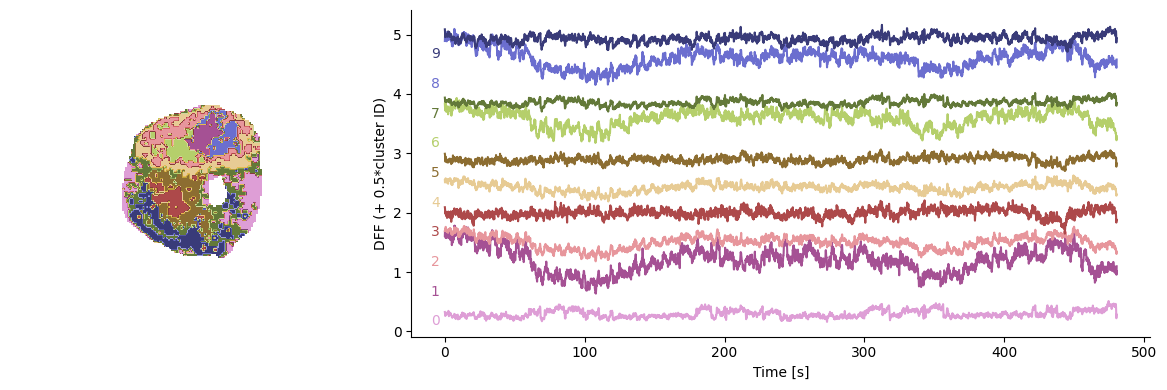

In [62]:
kmlabsImg = np.nan*np.ones(mask.data.shape)

kmlabsImg[mask.data>0] = kmlabs

fig, axs = plt.subplots(1,2,figsize=(12,4), gridspec_kw={'width_ratios':[1,2]})

axs[0].imshow(kmlabsImg,cmap=myClstMap,origin='upper')
axs[0].axis('off')

for i in range(nclst):
    axs[1].plot(time,centroids[i]+i*0.5, color=clstCMap.to_rgba(i+1))
    axs[1].text(-10,i*0.5+.1,str(i),color=clstCMap.to_rgba(i+1))
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('DFF (+ 0.5*cluster ID)')
myAxisTheme(axs[1])
fig.tight_layout()
fig.savefig(saveDir+sep+'ROIcluster_kn{}_3d.pdf'.format(nclst))

<Axes: xlabel='Time [s]', ylabel='\nROIs (n = 10)'>

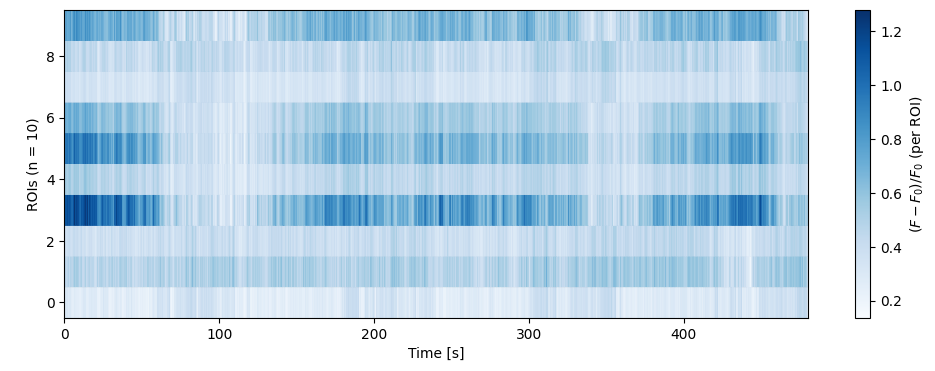

In [63]:
permutation = [0,3,5,1,4,8,2,7,9,6]
fig, ax = plt.subplots(1,1,figsize=(12,4))
plotDFFheatmap(time, centroids[permutation,:], ax, fig)

#### Generate ROIs and split into 16 or 32 wedges

In [69]:
# draw a mask to constrain which pixels will be included inthe correlation analysis
viewer = napari.view_image(dffMP)
if exists(sep.join([preprocDir,'EBctr.npy'])):
    ebcenter = np.load(sep.join([preprocDir,'EBctr.npy']))
    eblongax = np.load(sep.join([preprocDir,'EBlax.npy']))
    ebshortax = np.load(sep.join([preprocDir,'EBsax.npy']))
    viewer.add_points(ebcenter, size=5, name='EBctr')
    viewer.add_shapes(eblongax, name='EBlax', shape_type='line', edge_color='cyan')
    viewer.add_shapes(ebshortax,name='EBsax',shape_type='line',edge_color='blue')
    

c:\Users\FANG\anaconda3\envs\fly2p\lib\site-packages\numpy\core\numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
c:\Users\FANG\anaconda3\envs\fly2p\lib\site-packages\numpy\core\numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
c:\Users\FANG\anaconda3\envs\fly2p\lib\site-packages\numpy\core\numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


c:\Users\FANG\anaconda3\envs\fly2p\lib\site-packages\numpy\core\numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
c:\Users\FANG\anaconda3\envs\fly2p\lib\site-packages\napari\layers\shapes\shapes.py:2545: RuntimeWarning: invalid value encountered in cast
  shape = np.ceil(
c:\Users\FANG\anaconda3\envs\fly2p\lib\site-packages\napari\layers\shapes\shapes.py:2545: RuntimeWarning: invalid value encountered in cast
  shape = np.ceil(
c:\Users\FANG\anaconda3\envs\fly2p\lib\site-packages\napari\layers\shapes\shapes.py:2545: RuntimeWarning: invalid value encountered in cast
  shape = np.ceil(
c:\Users\FANG\anaconda3\envs\fly2p\lib\site-packages\napari\layers\base\base.py:1583: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
c:\Users\FANG\anaconda3\envs\fly2p\lib\site-packages\napari\layers\shapes\shapes.py:2545: Ru

In [70]:
ebcenter = viewer.layers["EBctr"].data[0]
eblongax = viewer.layers["EBlax"].data[0]
ebshortax = viewer.layers["EBsax"].data[0]
if not exists(sep.join([preprocDir])): makedirs(sep.join([preprocDir]))
np.save(sep.join([preprocDir,'EBctr']), ebcenter)
np.save(sep.join([preprocDir,'EBlax']), eblongax)
np.save(sep.join([preprocDir,'EBsax']), ebshortax)
viewer.close()

In [71]:
EBslices=16
startLoc=3

condition = 'white15Dark'

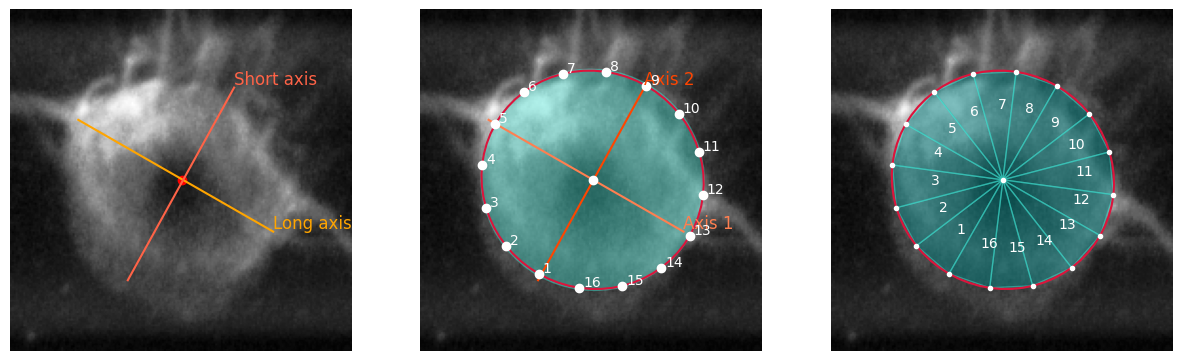

In [72]:
EBaxisL, EBaxisS, ellipseRot, ebcenter, EBoutline = generateEBellipse(eblongax,ebshortax,ebcenter,printResults = False)
EBroiPts, EBroiPolys = constructEBROIs(ebcenter, EBoutline, nsteps=EBslices, st=startLoc)

refEBimg = np.mean(stackMPMC,axis=0).T
fig = plotEBshapelyROIs(refEBimg, ebcenter, EBaxisL, EBaxisS, ellipseRot, EBoutline, EBroiPts, EBroiPolys)
fig.savefig(saveDir+sep+'_'.join(['polyRoiConstruction',genotype, region, flyID, condition, trial])+'.pdf')

In [84]:
dffROI = getDFFfromEllipseROI(EBroiPts,EBroiPolys,dffXarray)
time = dffXarray.coords['volumes [s]'].values

C:\Users\FANG\AppData\Local\Temp\ipykernel_2144\1274859911.py:4: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patch = ppatch.Ellipse(ebcenter, EBaxisL.length, EBaxisS.length, -ellipseRot, alpha = 0.4, color='tomato')


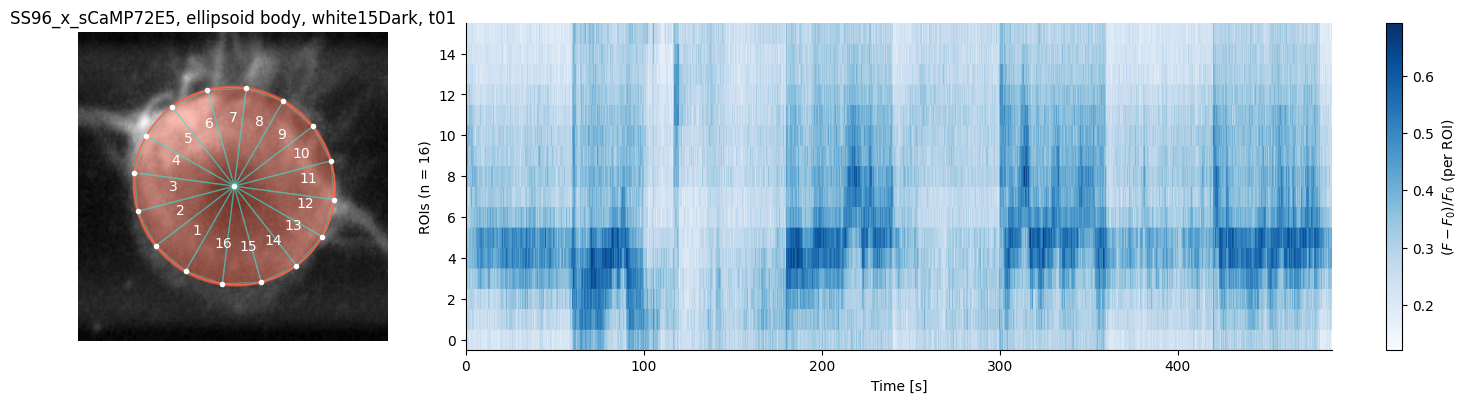

In [107]:
fig, axs = plt.subplots(1,2, figsize=(15,4),gridspec_kw={'width_ratios':[1,3.5]})
axs[0].imshow(np.mean(stackMPMC,axis=0).T,cmap='Greys_r', origin='lower')#, vmin=0, vmax=0.7*np.max(stackMP))

patch = ppatch.Ellipse(ebcenter, EBaxisL.length, EBaxisS.length, -ellipseRot, alpha = 0.4, color='tomato')

axs[0].add_patch(patch)
axs[0].plot(EBoutline.coords.xy[0],EBoutline.coords.xy[1], color='tomato', linewidth=1)

for s in range(len(EBroiPts)-1):
    roiPatch = ppatch.Polygon(EBroiPolys[s],alpha=0.4, edgecolor='turquoise', facecolor='none')
    axs[0].add_patch(roiPatch)
    axs[0].plot(EBroiPts[s+1][0],EBroiPts[s+1][1], 'w.')
    labcoord = Polygon(EBroiPolys[s]).centroid.coords.xy
    axs[0].text(labcoord[0][0],labcoord[1][0], str(s+1), color='w')

axs[0].plot(EBroiPts[0][0],EBroiPts[0][1], 'w.')
axs[0].axis('off')
axs[0].set_title(', '.join([genotype, region, condition, trial]))

axs[1] = plotDFFheatmap(time, dffROI, axs[1], fig) #vmax=1.5)
myAxisTheme(axs[1])

fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['roiMap-dFFtimeseries',genotype, region, flyID, condition, trial])+'.pdf')

#### Compute PVA

In [80]:
def computePVA (locs, weights):
    # compute population vector average

    nsteps = weights.shape[0]
    nvol = weights.shape[1]
    pva_x = np.cos(np.reshape(np.tile(locs,nvol),[nvol,nsteps])).T*weights
    pva_y = np.sin(np.reshape(np.tile(locs,nvol),[nvol,nsteps])).T*weights

    pva = np.vstack((sum(pva_x)/len(pva_x), sum(pva_y)/len(pva_x)))
    return pva


In [91]:
nsteps = EBslices
roiArcPos = np.linspace(0,2*np.pi,nsteps+1)[:-1]



pva = computePVA(roiArcPos,dffROI)
pvaRad = np.arctan2(pva[1,:],pva[0,:])
pvaLen = np.hypot(pva[0,:],pva[1,:])

PVAst = 3#7.5
pvaROI = np.mod((np.unwrap(pvaRad,np.pi) - pvaRad[0]) * nsteps/(2*np.pi) + PVAst, nsteps)

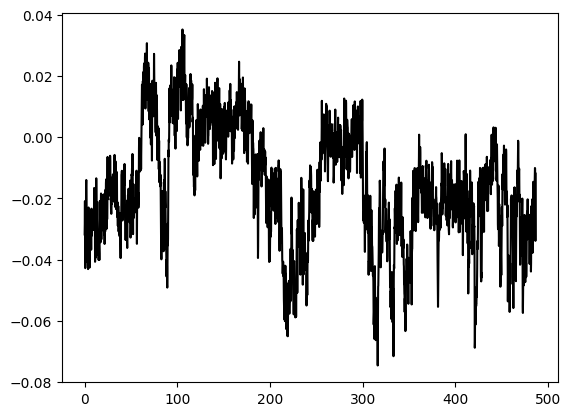

In [102]:
#plt.plot(time, computePVA(roiArcPos,dffROI)[0],'k')
#plt.plot(time,)
#pva.shape

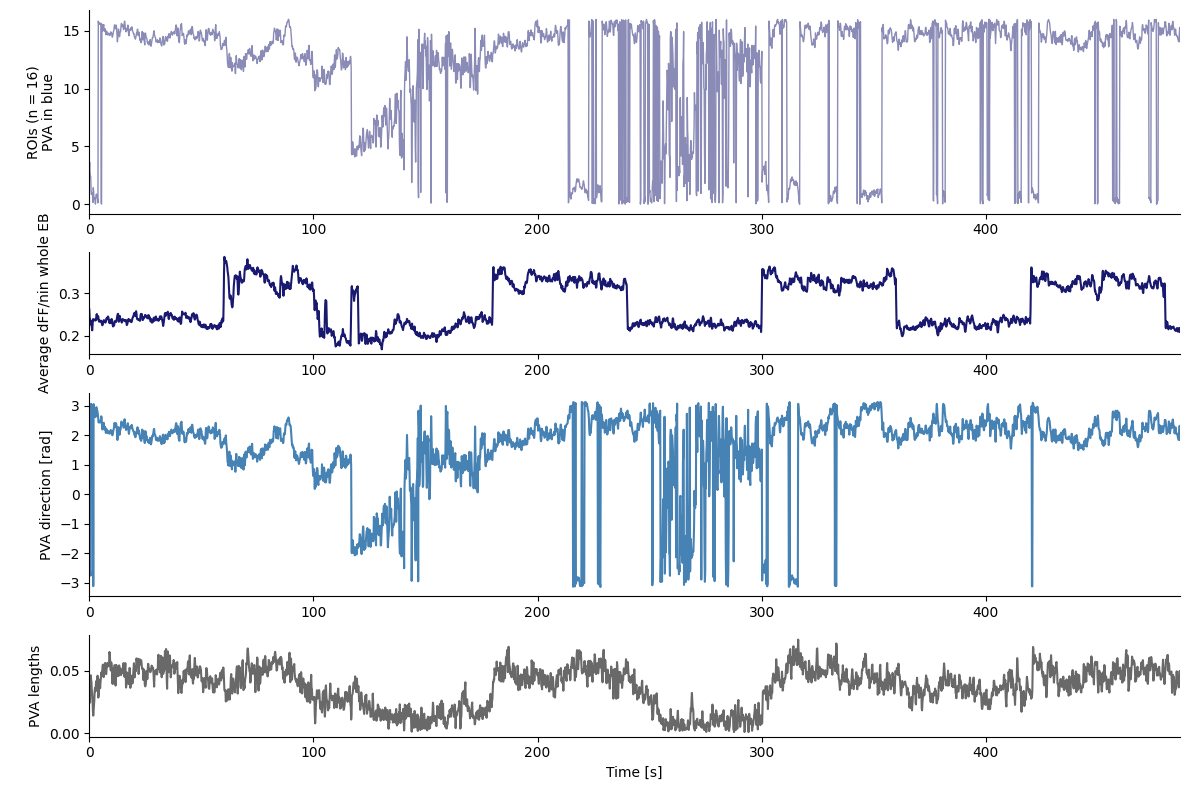

In [153]:
fig, axs = plt.subplots(4,1,figsize=(12,8),gridspec_kw={'height_ratios':[1,0.5,1,0.5]})

#cax = axs[0].pcolor(time,np.arange(0,nsteps+1),dffROI,cmap='Blues',edgecolors='face')
cax = ax.pcolor(time,np.arange(0,dffROI.shape[0]),dffROI,cmap='Blues',edgecolors='face',shading='auto')

axs[0].set_ylabel('\nROIs (n = {0})\nPVA in blue'.format(nsteps))
axs[0].plot(time,pvaROI,'-',color='midnightblue',linewidth=1,alpha=0.5)

axs[1].plot(time,meanDFF2,color='midnightblue')
axs[1].set_ylabel('Average dFF/nin whole EB')

axs[2].plot(time,pvaRad,color='steelblue')
axs[2].set_ylabel('PVA direction [rad]')

axs[3].plot(time,pvaLen,color='dimgrey')
axs[3].set_ylabel('PVA lengths')
axs[3].set_xlabel('Time [s]')

for ax in axs:
    myAxisTheme(ax)
    ax.set_xlim(time[0],time[-1])

fig.tight_layout()
#fig.savefig(saveDir)

#### Generate data object and save to disk

In [29]:
roiDf = pd.DataFrame(data = centroids.T, columns = ['roi{}'.format(i+1) for i in range(nclst)])
roiDf['time [s]'] = time
roiDf.head()

NameError: name 'centroids' is not defined

In [25]:
expMetadata = {
    'tiffilename': rawTiff,
    'genotype': genotype,
    'flyid': flyID,
    'trial':trial,
    'condition':'test',
    'roitype': "corr",
    'brainregion': region
}

imgTS_corrroi = imp.imagingTimeseries(
    imgMetadata = basicMetadat,
    expMetadata = expMetadata,
    refImage = refImg, 
    dffStack = dffXarray, 
    F0stack = F0Xarray,
    roitype = "corr",
    roiMask = kmlabsImg, 
    roiDFF = roiDf
)

path2imgdat = imgTS_corrroi.saveData(preprocDir,'')

In [26]:
# To load data from previously save files into object: 
imgTS_load = imp.loadImagingTimeseries(path2imgdat)

IOStream.flush timed out
